In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [43]:
def gen_photons(img, site_x, site_y, w_beam, avg_photons):
    n_photons = np.random.poisson(avg_photons)
    photons_x, photons_y = np.random.normal(site_x, w_beam, n_photons), np.random.normal(site_y, w_beam, n_photons)
    for x, y in zip(photons_x, photons_y):
        img[int(np.rint(x)), int(np.rint(y))] += 0.8
    return img

def gen_img(img_width, img_height, occupation, lattice_constant, lattice_offset, n_dark=1, n_light=9, noise=2.2):
    img = np.random.uniform(2, noise, (img_width, img_height))
    n_sites = len(occupation)
    sites_x = lattice_constant[0] * np.arange(n_sites) + lattice_offset[0]
    sites_y = lattice_constant[1] * np.arange(n_sites) + lattice_offset[1]
    for i in range(n_sites):
        img = gen_photons(img, sites_x[i], sites_y[i], w_beam, n_dark + n_light * occupation[i])
    return img

In [44]:
img_width, img_height = 128, 16
n_sites = 15
w_beam = 1.1

lattice_constant = np.array([5.9, -0.058])
lattice_offset = np.array([14, 7.303])

images, occupancies = map(list, zip(*[gen_img(img_width, img_height, n_sites, lattice_constant, lattice_offset) for x in range(5000)]))
np.savez_compressed('generated_data.npz', images, occupancies)

TypeError: object of type 'int' has no len()

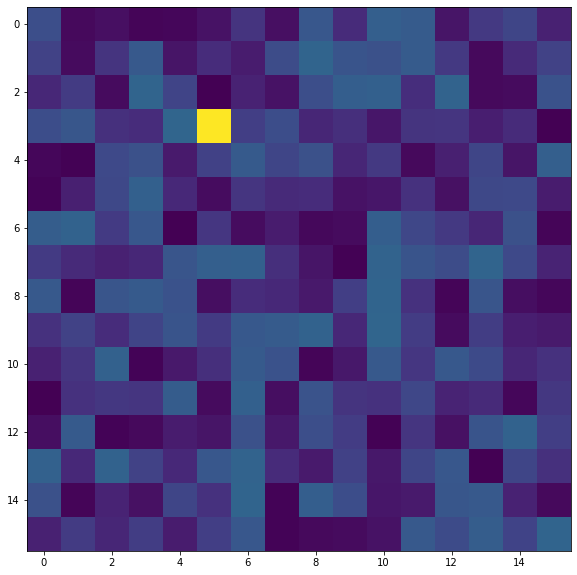

In [46]:
random_index = np.random.randint(0, len(images))

plt.figure(figsize=(20, 10))
plt.imshow(np.transpose(images[random_index]))
plt.show()

# Single Site Image Generation

After trying to make a dataset with all 15 simulated sites, I found that simple convolutional neural networks were unable to correctly learn the difference between occupied an unoccupied sites. So proceeding forward I'll try to train a network that's able to identify one site, which I'll switch around the location of in the image. I believe that switching the location of the site in the image may also just generally be a good practice, as with the convolutional network, we aren't trying to identify localized parameters as much we are patterns.

The code below is intended to generate a 16x16 image where the atom center can be located within a smaller 8x8 area in the center of the image.

In [78]:
img_width, img_height = 16, 16
w_beam = 1.1
n_sites = 1
lattice_constant = np.zeros(2)
n_train = 5000
n_testing = 500

training_occupancies = np.random.randint(0, 2, (n_train, 1))
training_centers = np.random.uniform(4, 8, (n_train, 2))

training_images = [gen_img(img_width, img_height, occupation, lattice_constant, center) for occupation, center in zip(training_occupancies, training_centers)]

np.savez_compressed('training.npz', images=training_images, occupancies=training_occupancies)

test_occupancies = np.random.randint(0, 2, (n_testing, 1))
test_centers = np.random.uniform(4, 8, (n_testing, 2))

test_images = [gen_img(img_width, img_height, occupation, lattice_constant, center) for occupation, center in zip(test_occupancies, test_centers)]
np.savez_compressed('testing.npz', images=test_images, occupancies=test_occupancies)

[0]


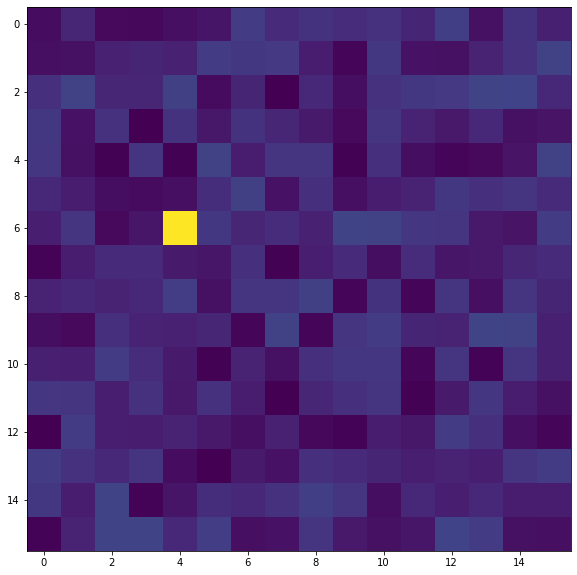

In [73]:
random_index = np.random.randint(0, len(images))

print(occupancies[random_index])

plt.figure(figsize=(20, 10))
plt.imshow(np.transpose(images[random_index]))
plt.show()

# Three Site Image Generation

For three sites we now need to consider every possible configuration. If we independently decide whether each site will be one or not then we are less likely to get very low or very high numbers of occupied sites.

In [231]:
img_width, img_height = 64, 64
w_beam = 1.1
n_sites = 3
n_train = 500
n_test = 50

lattice_constant = np.array([5.9, -0.058])

# Rather than having a lattice offset lets 
#just randomly pick a place to begin the lattice within the bounds of the image

# lattice_offset = np.array([14, 7.303]) 

def enumerate_occupancies(n_sites):
    occupancies = []
    def helper(depth, occupancy):
        if depth == n_sites:
            occupancies.append(occupancy)
        else:
            empty, full = np.append(occupancy, 0), np.append(occupancy, 1)
            helper(depth + 1, empty)
            helper(depth + 1, full)
        return 
    helper(0, np.empty(0))
    return np.array(occupancies)

possible_occupancies = enumerate_occupancies(3)

train_images = np.empty((0, img_width, img_height))
train_occupancies = np.empty((0, n_sites))

for occupation in possible_occupancies:
    train_images = np.append(train_images, [gen_img(img_width, img_height, occupation, lattice_constant, np.random.uniform(16, 40, 2)) for x in range(n_train)], axis=0)
    train_occupancies = np.append(train_occupancies, np.array([occupation for x in range(n_training)]), axis=0)

np.savez_compressed('training.npz', images=train_images, occupancies=train_occupancies)
    
test_images = np.empty((0, img_width, img_height))
test_occupancies = np.empty((0, n_sites))

for occupation in possible_occupancies:
    test_images = np.append(test_images, [gen_img(img_width, img_height, occupation, lattice_constant, np.random.uniform(16, 40, 2)) for x in range(n_test)], axis=0)
    test_occupancies = np.append(test_occupancies, np.array([occupation for x in range(n_test)]), axis=0)
    
np.savez_compressed('testing.npz', images=test_images, occupancies=test_occupancies)

[1. 0. 0.]


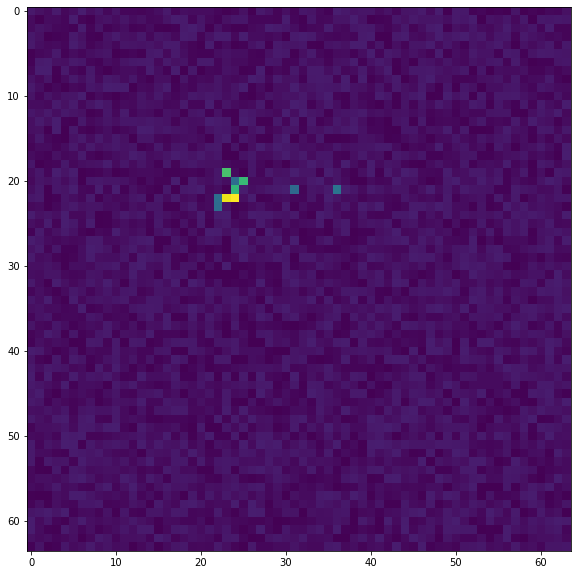

In [230]:
random_index = np.random.randint(0, len(train_images))

print(train_occupancies[random_index])

plt.figure(figsize=(20, 10))
plt.imshow(np.transpose(train_images[random_index]))
plt.show()